<a href="https://colab.research.google.com/github/qu-bit1/NeuralBlend/blob/main/Final_nb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Segmentation**

In [1]:
!pip install kaggle

In [2]:
!pip install tensorflow-addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 4.1 MB/s eta 0:00:00


In [3]:
!pip install opendatasets

In [4]:
!pip install opencv-python

In [5]:
import tensorflow as tf
import keras
import numpy as np
import os
import cv2
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
import warnings
import opendatasets as od
import pandas as pd
warnings.filterwarnings("ignore", category=DeprecationWarning)  #Ignores all Deprecation warnings
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, AveragePooling2D, Dropout
from tensorflow.keras.layers import Conv2DTranspose, concatenate, Activation, Flatten, Dense, BatchNormalization , UpSampling2D

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [6]:
#Downloading Dataset from Kaggle
od.download("https://www.kaggle.com/datasets/rajkumarl/people-clothing-segmentation")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: qubit64
Your Kaggle Key: ··········


100%|██████████| 616M/616M [00:10<00:00, 63.5MB/s]


### **Dice Loss**

Defining a fucntion to calculate the Dice Loss

**Dice loss**, also known as the Sørensen-Dice coefficient or F1 score, is a loss function commonly used in image segmentation tasks to measure the dissimilarity between the predicted segmentation and the ground truth.




In [7]:
def dice_loss(y_true, y_pred):
    smooth = 1e-5                                 #used to avoid division by zero
    #Typecasting the Data to float32
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    #calculates the intersection between the y_true and y_pred tensors
    intersection = tf.reduce_sum(y_true * y_pred)

    #calculates the union of the y_true and y_pred tensors
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)

    dice = (2.0 * intersection + smooth) / (union + smooth)
    loss = 1.0 - dice
    return loss

Loading the images and their corresponding masks using OpenCV (cv2).

The code:

* Iterates through each image file in dataset_dir1 and loads the corresponding mask file by constructing the mask filename based on the image filename.

* The images and masks are then resized to a desired size of 512x512 pixels using cv2.resize().

* The resized images and masks are stored in separate lists (images and masks).
* Finally, the lists are converted to NumPy arrays using np.array() and assigned to image_train and mask_train, respectively.

In [8]:
#Path to DataSet Directory
dataset_dir1 = '/content/people-clothing-segmentation/png_images/IMAGES'
dataset_dir2 = '/content/people-clothing-segmentation/png_masks/MASKS'

# Initialize lists to store images and labels
images = []
masks = []

# Iterate through each image file
for filename in os.listdir(dataset_dir1):
    # Load the image using OpenCV
    mask_name = "seg_"+filename[4:]

    image = cv2.imread(os.path.join(dataset_dir1, filename))
    mask = cv2.imread(os.path.join(dataset_dir2, mask_name))

    # Resize the image to a desired size (e.g., 128x128)
    image = cv2.resize(image, (512, 512,))
    mask = cv2.resize(mask, (512, 512,))

    # Append the image to the images list
    images.append(image)
    masks.append(mask)

# Convert the lists to NumPy arrays
image_train = np.array(images)
mask_train = np.array(masks)

In [9]:
print("The shape of the Masks in the training Data:{})".format(mask_train.shape))

The shape of the Masks in the training Data:(1000, 512, 512, 3))


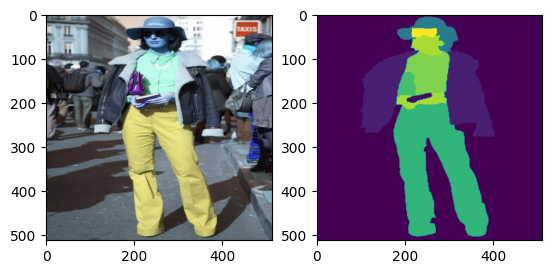

In [10]:
# Data Inspection and Visualization
plt.subplot(1,2,1)
plt.imshow(image_train[10])

plt.subplot(1,2,2)
plt.imshow(mask_train[10][:,:,0])
plt.show()

In [11]:
# Assuming you have an array called 'image_train'
image_data_type = image_train.dtype
print("Image data type:", image_data_type)
print(image_train.shape)

# Assuming you have an array called 'mask_train'
mask_data_type = mask_train.dtype
print("Mask data type:", mask_data_type)
print(mask_train.shape)

Image data type: uint8
(1000, 512, 512, 3)
Mask data type: uint8
(1000, 512, 512, 3)


In [12]:
masked_image = cv2.bitwise_and(image_train, image_train, mask=mask_train)

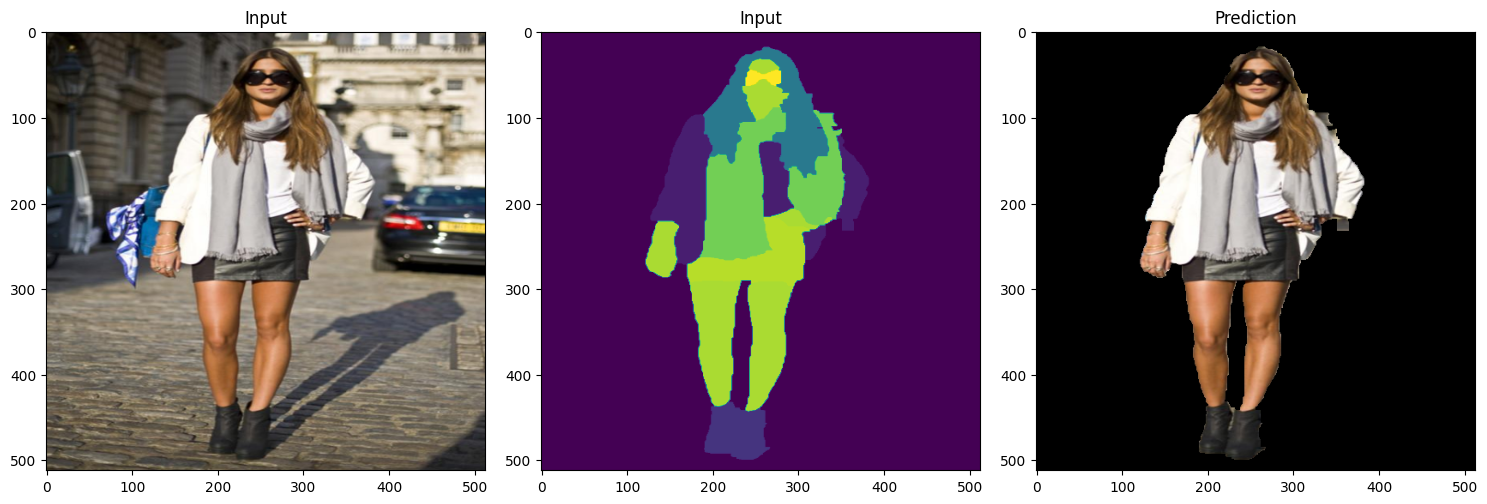

In [13]:
plt.figure(figsize=(15, 15))
plt.subplot(1, 3, 1)
x_train1 = cv2.cvtColor(image_train[21], cv2.COLOR_BGR2RGB)
plt.imshow(x_train1)
plt.title('Input')

# Plot the input image
plt.subplot(1, 3, 2)
plt.imshow(mask_train[21][:,:,0])
plt.title('Input')

# Plot the prediction
plt.subplot(1, 3, 3)
rgb_image = cv2.cvtColor(masked_image[21], cv2.COLOR_BGR2RGB)

# Display the RGB image using Matplotlib
plt.imshow(rgb_image)
plt.title('Prediction')

plt.tight_layout()
plt.show()

## **Class: MultiLayerPerceptron**

Following code represents a multi-layer perceptron (MLP) neural network model with convolutional layers.


In [14]:
class MultiLayerPerceptron():

    def __init__(self, input):
        super().__init__()
        self.inp = input

        # Define convolutional layers with ReLU activation
        self.conv_relu = Conv2D(1, kernel_size=3, strides=(1, 1), padding='SAME', activation='relu')

        # Define a convolutional layer
        self.conv = Conv2D(1, kernel_size=3, strides=(1, 1), padding='SAME')

        # Call the MLP function to build the network
        self.out = self.MLP()

    def MLP(self):
        # Function to build the Multi-Layer Perceptron

        # Apply convolution followed by ReLU activation
        out = self.conv_relu(self.inp)

        # Apply convolution without activation
        out = self.conv(self.inp)

        return out


In [15]:
class ConvBlockAttentionModule():

  def __init__(self,input) :
    # super().__init__()
    self.out = self.CBAM(input)


  def CBAM(self,input):

    max1 = tf.reduce_max(input,axis=-1,keepdims = True)
    avg1 = tf.reduce_mean(input,axis=-1,keepdims = True)
    max1 = MultiLayerPerceptron(max1).out
    avg1 = MultiLayerPerceptron(avg1).out

    # max1 = MaxPooling2D(pool_size=(2,2),strides = 1, padding = 'same')(input)
    # avg1 = AveragePooling2D(pool_size=(2,2),strides = 1, padding = 'same')(input)

    cam = tf.add(max1,avg1)
    cam = tf.keras.activations.sigmoid(cam)
    out1 = tf.math.multiply(cam,input)

    max2 = MaxPooling2D(pool_size = (2,2), strides = 1, padding = 'SAME')(out1)
    # print(np.shape(max2))
    avg2 = AveragePooling2D(pool_size = (2,2), strides = 1, padding = 'SAME')(out1)
    # print(np.shape(avg2))
    out2 = tf.concat([avg2,max2],axis = -1)
    # print(np.shape(out2))
    out2 = Conv2D(1,kernel_size=3,strides=(1,1), padding= 'same')(out2)
    # print(np.shape(out2))
    out2 = tf.keras.activations.sigmoid(out2)
    # print(np.shape(out2))

    out = tf.math.multiply(out1,out2)

    return out

In [16]:
class DownSampling():

  def __init__(self,input,n_filters):
    # super().__init__()
    self.inp = input
    self.nf = n_filters
    self.skip = self.Down_skip()
    self.output = self.Down_out()

  def Down_out(self) :

    out = Conv2D(self.nf,kernel_size=3,strides = (1,1),padding = 'same')(self.inp)
    out = BatchNormalization(axis=-1)(out)
    out = tf.keras.layers.LeakyReLU(alpha = 0.2)(out)
    out = Conv2D(self.nf,kernel_size=3,strides = (1,1),padding = 'same')(out)
    out = BatchNormalization(axis=-1)(out)
    out = tf.keras.layers.LeakyReLU(alpha = 0.2)(out)
    avg = AveragePooling2D(pool_size=(2,2),strides = 2, padding = 'valid')(out)

    # output = ConvBlockAttentionModule(avg).out
    output = avg

    return output

  def Down_skip(self) :

    out = Conv2D(self.nf,kernel_size=3,strides = (1,1),padding = 'same')(self.inp)
    out = BatchNormalization(axis=-1)(out)
    out = tf.keras.layers.LeakyReLU(alpha = 0.2)(out)
    out = Conv2D(self.nf,kernel_size=3,strides = (1,1),padding = 'same')(out)
    out = BatchNormalization(axis=-1)(out)
    out = tf.keras.layers.LeakyReLU(alpha = 0.2)(out)


    return out


In [17]:
tf.keras.layers.UpSampling2D(
    size=(2,2), data_format=None , interpolation ='bilinear'
)

In [18]:
class UpSampling():

  def __init__(self,input,skip,n_filters):
    # super().__init__()
    self.inp = input
    self.sk = skip
    self.nf = n_filters
    self.out = self.UpS();

  def UpS(self) :

    up = UpSampling2D(size=(2, 2), interpolation="bilinear")(self.inp)
    up = Conv2D(self.nf, kernel_size=3, activation="relu", padding="same")(up)
    up = Conv2D(self.nf,kernel_size=3,strides = (1,1),padding = 'same')(up)
    up = BatchNormalization(axis=-1)(up)
    up = tf.keras.layers.LeakyReLU(alpha = 0.2)(up)
    up = Conv2D(self.nf,kernel_size=3,strides = (1,1),padding = 'same')(up)
    up = BatchNormalization(axis=-1)(up)
    up = tf.keras.layers.LeakyReLU(alpha = 0.2)(up)

    # out = ConvBlockAttentionModule(up).out
    out = up

    out = concatenate([out,self.sk], axis = 3)

    return out


In [19]:
class ResidualBlock():

  def __init__(self,input,n_filters):
    # super().__init__()
    self.inp = input
    self.nf = n_filters
    self.out = self.Residual();

  def Residual (self) :

    res = Conv2D(self.nf,kernel_size=3,strides = (1,1),padding = 'same')(self.inp)
    res = BatchNormalization(axis=-1)(res)
    res = tf.keras.layers.LeakyReLU()(res)
    res = Conv2D(self.nf,kernel_size=3,strides = (1,1),padding = 'same')(res)
    res = BatchNormalization(axis=-1)(res)

    out = tf.keras.layers.Add()([res,self.inp])

    out = tf.keras.layers.ReLU()(out)

    # out = ConvBlockAttentionModule(out).out

    return out

In [20]:
class UNet_Model():

  def __init__(self,input_size,n_filters=4,n_classes = 59):
    # super().__init__()
    self.inps = input_size
    self.nf = n_filters
    self.nc = n_classes
    self.model = self.UNet();


  def UNet(self) :

    inputs = Input(self.inps)

    down1 = DownSampling(inputs,self.nf)
    down2 = DownSampling(down1.output,self.nf*2)
    down3 = DownSampling(down2.output,self.nf*4)
    down4 = DownSampling(down3.output,self.nf*8)
    down5 = DownSampling(down4.output,self.nf*16)

    res1 = ResidualBlock(down5.output,self.nf*16)
    res2 = ResidualBlock(res1.out,self.nf*16)
    res3 = ResidualBlock(res2.out,self.nf*16)
    res4 = ResidualBlock(res3.out,self.nf*16)

    up1 = UpSampling (res4.out,down5.skip,self.nf*16)
    up2 = UpSampling (up1.out,down4.skip,self.nf*8)
    up3 = UpSampling (up2.out,down3.skip,self.nf*4)
    up4 = UpSampling (up3.out,down2.skip,self.nf*2)
    up5 = UpSampling (up4.out,down1.skip,self.nf)

    final = Conv2D(self.nc,1,padding = 'same')(up5.out)
    model = tf.keras.Model(inputs=inputs,outputs=final)

    return model

In [21]:
#from keras.optimizers import SGD

#sgd = SGD(lr=0.001, momentum=0.9)

u = UNet_Model((512,512,3)).model
u.compile(optimizer='adam',loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=['accuracy'])
u.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 512, 512, 3)]        0         []                            
                                                                                                  
 conv2d_2 (Conv2D)           (None, 512, 512, 4)          112       ['input_1[0][0]']             
                                                                                                  
 batch_normalization_2 (Bat  (None, 512, 512, 4)          16        ['conv2d_2[0][0]']            
 chNormalization)                                                                                 
                                                                                                  
 leaky_re_lu_2 (LeakyReLU)   (None, 512, 512, 4)          0         ['batch_normalization_2[0]

In [22]:
np.shape(mask_train[1])

(512, 512, 3)

In [23]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

In [24]:
masks_train = np.expand_dims(mask_train[:,:,:,0], axis =-1)
masks_train.shape

(1000, 512, 512, 1)

In [25]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [26]:
train_dataset = tf.data.Dataset.from_tensor_slices((image_train[0:900], masks_train[0:900]))
train_dataset = train_dataset.batch(15)
test_dataset = tf.data.Dataset.from_tensor_slices((image_train[901:1000], masks_train[901:1000]))
test_dataset = test_dataset.batch(15)

In [27]:
# u.load_weights("")

Model Training

currently commented because model sufficiently trained

In [39]:
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint_path = "/content/drive/MyDrive/segmodel_neuralblend/model.ckpt"
checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_loss', verbose=1, save_weights_only=True, save_best_only=True, mode='min')

history = u.fit(train_dataset, epochs=10, validation_data=test_dataset, callbacks=[checkpoint])

Epoch 1/10
60/60 [==============================] - ETA: 0s - loss: 0.7539 - accuracy: 0.8209
Epoch 1: val_loss improved from inf to 0.75516, saving model to /content/drive/MyDrive/segmodel_neuralblend/model.ckpt
60/60 [==============================] - 34s 564ms/step - loss: 0.7539 - accuracy: 0.8209 - val_loss: 0.7552 - val_accuracy: 0.8143
Epoch 2/10
60/60 [==============================] - ETA: 0s - loss: 0.7305 - accuracy: 0.8236
Epoch 2: val_loss improved from 0.75516 to 0.73589, saving model to /content/drive/MyDrive/segmodel_neuralblend/model.ckpt
60/60 [==============================] - 34s 563ms/step - loss: 0.7305 - accuracy: 0.8236 - val_loss: 0.7359 - val_accuracy: 0.8171
Epoch 3/10
60/60 [==============================] - ETA: 0s - loss: 0.7109 - accuracy: 0.8260
Epoch 3: val_loss improved from 0.73589 to 0.72353, saving model to /content/drive/MyDrive/segmodel_neuralblend/model.ckpt
60/60 [==============================] - 34s 560ms/step - loss: 0.7109 - accuracy: 0.8260

In [40]:
# Assuming you already have the trained model 'unet'
# Take a single sample from the training data
x_test = image_train[122]
x_test = np.expand_dims(x_test, axis=0)

# Make predictions
prediction = u.predict(x_test)
print(prediction.dtype)
pred_mask = create_mask(prediction)
print(pred_mask.dtype)
print(pred_mask.shape)
print(prediction.shape)

1/1 [==============================] - 0s 26ms/step
float32
<dtype: 'int64'>
(512, 512, 1)
(1, 512, 512, 59)


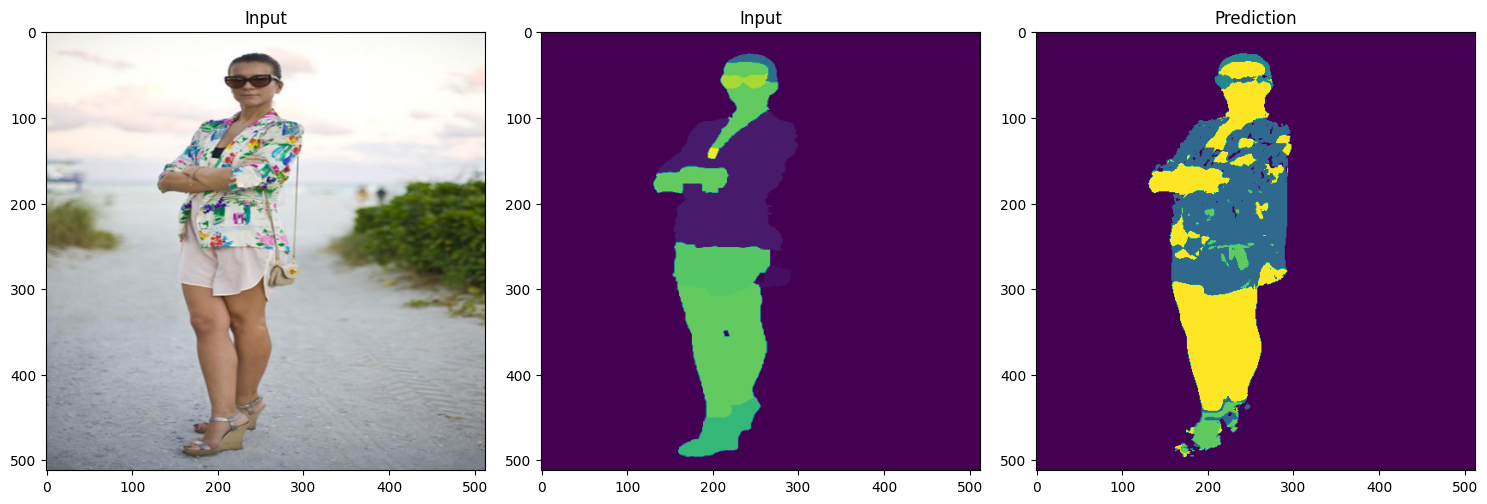

In [41]:
import matplotlib.pyplot as plt
import cv2

# Plot the input image
plt.figure(figsize=(15, 15))
plt.subplot(1, 3, 1)
x_train1 = cv2.cvtColor(image_train[122], cv2.COLOR_BGR2RGB)
plt.imshow(x_train1)
plt.title('Input')

# Plot the input image
plt.subplot(1, 3, 2)
plt.imshow(mask_train[122][:,:,0])
plt.title('Input')

# Plot the prediction
plt.subplot(1, 3, 3)
plt.imshow(pred_mask)
plt.title('Prediction')

plt.tight_layout()
plt.show()


In [42]:

x_train1.shape
prediction.shape


(1, 512, 512, 59)

In [43]:
sample= cv2.imread('/content/vettel.jpg')
sample = cv2.resize(sample, (512, 512,))
sample = np.array(sample)

sample = np.expand_dims(sample, axis=0)

# Make predictions
prediction_gan = u.predict(sample)
print(prediction.dtype)
pred_mask_gan = create_mask(prediction_gan)
print(pred_mask_gan.dtype)
print(pred_mask_gan.shape)
print(prediction_gan.shape)

1/1 [==============================] - 0s 24ms/step
float32
<dtype: 'int64'>
(512, 512, 1)
(1, 512, 512, 59)


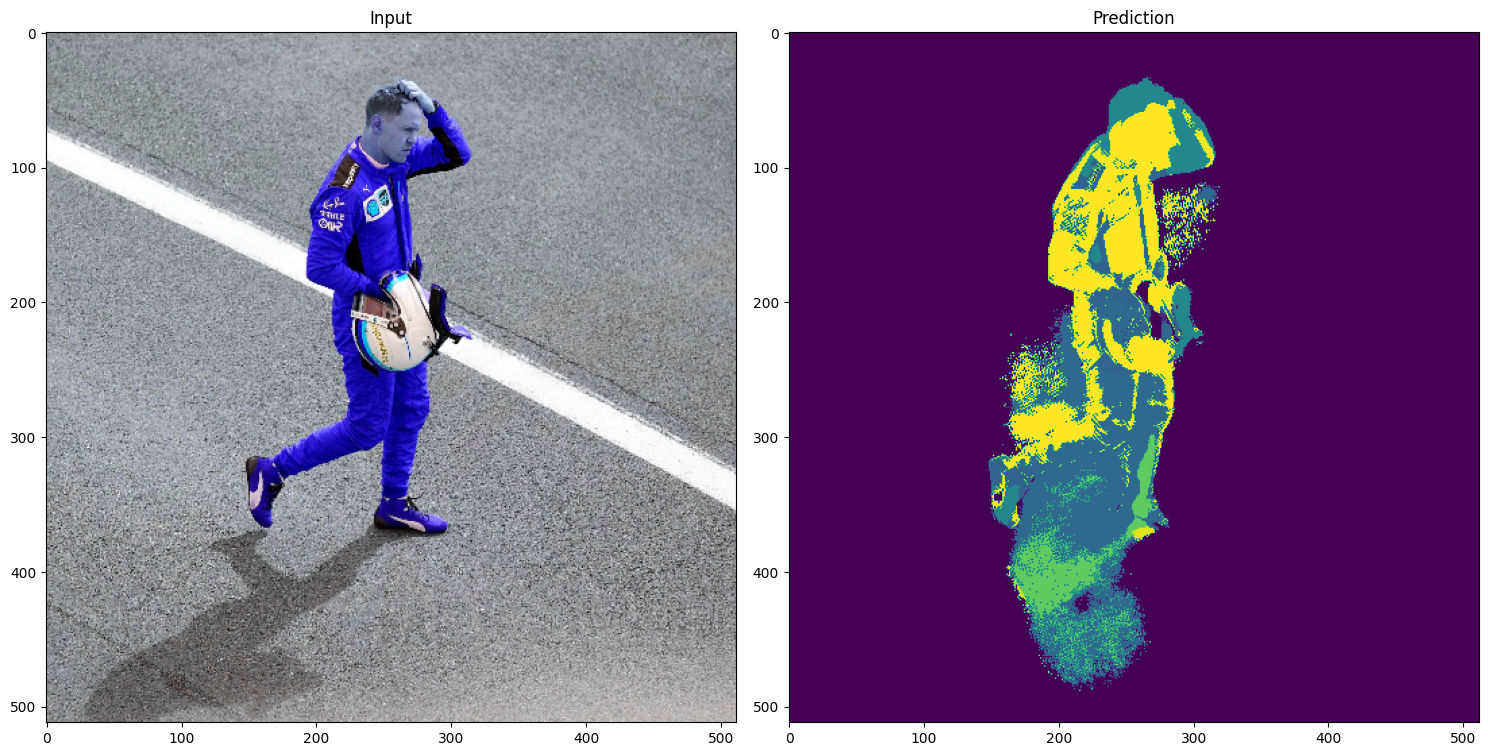

In [44]:
import matplotlib.pyplot as plt
import cv2

# Assuming you already have the trained model 'unet'
# Assuming you have the test data stored in 'x_test'



# Plot the input image
plt.figure(figsize=(15, 15))
plt.subplot(1, 2, 1)

plt.imshow(sample[0])
plt.title('Input')


# Plot the prediction
plt.subplot(1, 2, 2)
plt.imshow(pred_mask_gan)
plt.title('Prediction')

plt.tight_layout()
plt.show()

##**JUST TESTING**

## **CUTTING**

In [45]:
#image_train = np.array(x_train1)
mask_pred = np.array(pred_mask)
# mask_pred.shape
mask_pred.dtype
# image_train.dtype
# x_train1.size

dtype('int64')

In [46]:
mask_pred = mask_pred.astype(np.uint8)
mask_pred.shape

(512, 512, 1)

In [ ]:
# np.expand_dims(mask_train,axis=1)
# mask_pred.shape
# mask_pred1 = mask_pred[:,:,:,38]
# import numpy as np

# # Assuming you have a NumPy array called 'mask_train' with shape (x, y, z, 39)
# # mask_train_shape = mask_train.shape
# # new_mask_train_shape = np.delete(mask_train_shape, 3, axis=0)
# mask_pred1 = np.expand_dims(mask_pred, -1)
# mask_pred1 = np.concatenate([mask_pred,mask_pred,mask_pred], axis = -1)
# mask_pred1.shape

In [47]:
import numpy as np

# Assuming you have an array called 'image_train'
image_data_type = x_train1.dtype
print("Image data type:", image_data_type)

# Assuming you have an array called 'mask_train'
mask_data_type = mask_train.dtype
print("Mask data type:", mask_data_type)
# print(new_mask_train_shape)


Image data type: uint8
Mask data type: uint8


In [48]:
# # Assuming you have the necessary data for 'mask_train' and 'image_train'
# #mask_train = ...  # Define and initialize 'mask_train' properly
# image_train = np.array(x_train1)  # Define and initialize 'image_train' properly

# # Verify the shape and data type of 'mask_train[47]'
# print(mask_train[47].shape)
# print(mask_train[47].dtype)

# # Convert 'mask_train[47]' to the appropriate data type, if necessary
# mask_train_47 = mask_train[47].astype(np.uint8)

# Perform the bitwise masking operation
masked_image1 = cv2.bitwise_and(x_train1, x_train1, mask=mask_pred)


In [49]:
print(x_train1.shape)
print(masked_image1.shape)
print(mask_pred.shape)
# mask_pred = np.expand_dims(mask_pred,-1)
# mask_pred = np.concatenate([mask_pred,mask_pred,mask_pred], axis = -1)
# mask_pred.shape

(512, 512, 3)
(512, 512, 3)
(512, 512, 1)


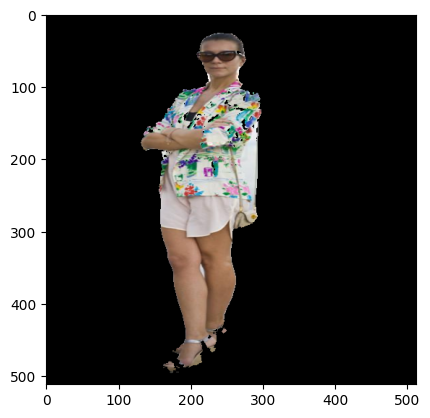

In [50]:
import matplotlib.pyplot as plt

plt.imshow(masked_image1)
plt.show()

(512, 512, 3)


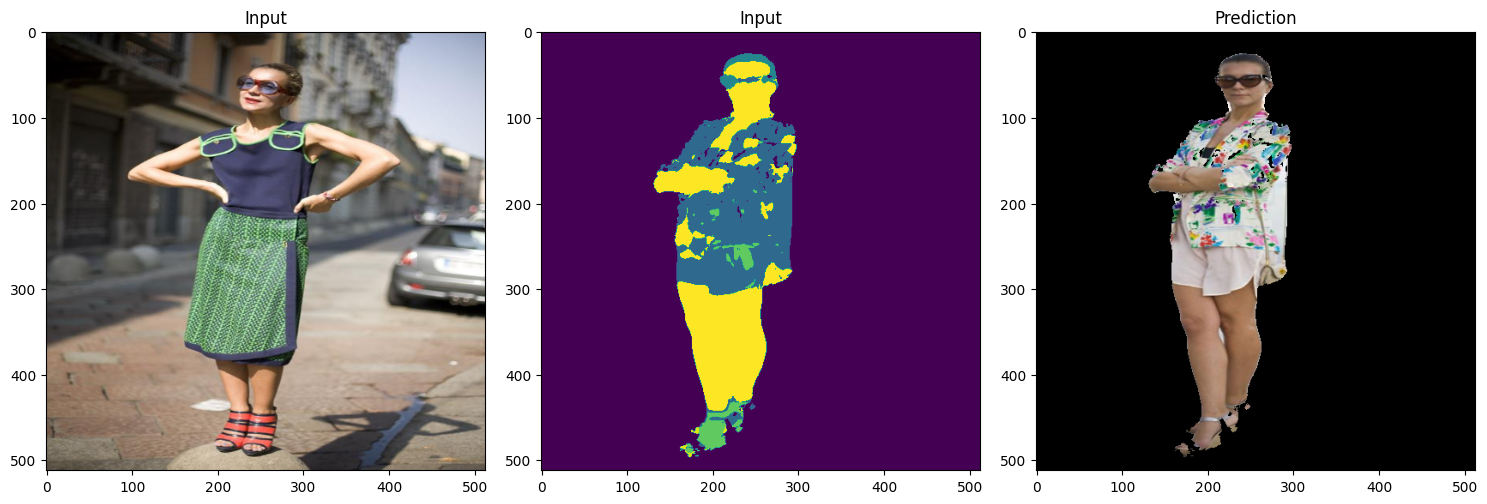

In [51]:
plt.figure(figsize=(15, 15))
plt.subplot(1, 3, 1)
x_train1 = cv2.cvtColor(image_train[70], cv2.COLOR_BGR2RGB)
plt.imshow(x_train1)
print(x_train1.shape)
plt.title('Input')

# Plot the input image
plt.subplot(1, 3, 2)
plt.imshow(mask_pred)
plt.title('Input')

# Plot the prediction
plt.subplot(1, 3, 3)
#rgb_image = cv2.cvtColor(masked_image1[21], cv2.COLOR_BGR2RGB)

# Display the RGB image using Matplotlib
plt.imshow(masked_image1)
plt.title('Prediction')

plt.tight_layout()
plt.show()

In [52]:
masked_image.shape

(1000, 512, 512, 3)

In [53]:
#masked_image = cv2.bitwise_and(image_train, image_train, mask=mask_train[47])

In [54]:
# def show_predictions(dataset=None, num=1):
#     """
#     Displays the first image of each of the num batches
#     """
#     if dataset:
#         for image, mask in dataset.take(num):
#             pred_mask = u.predict(image)
#             display([image[0], mask[0], create_mask(pred_mask)])
#     else:
#         display([image_train[8], masks_train[8],
#              create_mask(u.predict(image_train[8][tf.newaxis, ...]))])

# **STYLE TRANSFER**

In [55]:
od.download("https://www.kaggle.com/datasets/splcher/animefacedataset")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: qubit64
Your Kaggle Key: ··········


100%|██████████| 395M/395M [00:03<00:00, 109MB/s] 


In [2]:
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
import matplotlib.pyplot as plt
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.vgg19 import VGG19

In [3]:
import os
import cv2
import numpy as np

# Path to the dataset directory
dataset_dir = '/content/animefacedataset/images'


# Initialize lists to store images and labels
images = []
labels = []
i=0

# Iterate through each image file
for filename in os.listdir(dataset_dir[0:5000]):
    # Load the image using OpenCV
    image = cv2.imread(os.path.join(dataset_dir, filename))

    # Resize the image to a desired size (e.g., 128x128)
    image = cv2.resize(image, (512, 512,))

    # Append the image to the images list
    images.append(image)
    i+=1
    if i == 5000:
      break

# Convert the lists to NumPy arrays
x_train = np.array(images)

In [7]:
VGG_LAYERS = [
    'block1_conv1', 'block1_conv2',
    'block2_conv1', 'block2_conv2',
    'block3_conv1', 'block3_conv2',
    'block3_conv3', 'block3_conv4',
    'block4_conv1',
]

class WaveLet_pooling(tf.keras.layers.Layer):

    # def __init__(self, name):
    #     super(WaveLet_pooling, self).__init__(name=name)
    #     # Calculation of Haar Wavelets.
    #     self.kernel_LL = tf.constant([[1, 1], [1, 1]], dtype=tf.float32) / 4
    #     self.kernel_HH = tf.constant([[-1, 1], [-1, 1]], dtype=tf.float32) / 4

    # def call(self, inputs):
    #     LL_in, HH_in, tensor_in = inputs
    #     out_shape = tf.shape(tensor_in)
    #     LL = tf.nn.conv2d_transpose(LL_in, tf.expand_dims(tf.expand_dims(self.kernel_LL, axis=0), axis=-1), output_shape=out_shape, strides=[1, 2, 2, 1], padding='SAME')
    #     HH = tf.nn.conv2d_transpose(HH_in, tf.expand_dims(tf.expand_dims(self.kernel_HH, axis=0), axis=-1), output_shape=out_shape, strides=[1, 2, 2, 1], padding='SAME')
    #     return tf.concat([LL, HH, tensor_in], axis=-1)

    # def compute_output_shape(self, input_shape):
    #     _ip_shape = input_shape[0]
    #     shape = (
    #         _ip_shape[0],
    #         _ip_shape[1] * 2,
    #         _ip_shape[2] * 2,
    #         sum(ips[3] for ips in input_shape)
    #     )
    #     return shape
    def __init__(self, name):
        super(WaveLet_pooling, self).__init__(name=name)
        # Calculation of Haar Wavelets.
        sqrt_2 = tf.math.sqrt(tf.constant(2, dtype=tf.float32))
        L = tf.constant([[1, 1]], dtype=tf.float32) / sqrt_2
        H = tf.constant([[-1,1]], dtype=tf.float32) / sqrt_2

        self.LL = tf.reshape(tf.math.multiply(tf.transpose(L), L), (1, 2, 2, 1))
        # self.LH = tf.reshape(tf.math.multiply(tf.transpose(L), H), (1, 2, 2, 1))
        # self.HL = tf.reshape(tf.math.multiply(tf.transpose(H), L), (1, 2, 2, 1))
        self.HH = tf.reshape(tf.math.multiply(tf.transpose(H), H), (1, 2, 2, 1))

    def call(self, inputs):
        LL, HH = self.repeat_filters(inputs.shape[-1])
        return [
            tf.nn.conv2d(inputs, LL, strides=[1, 2, 2, 1], padding='SAME'),
            # tf.nn.conv2d(inputs, LH, strides=[1, 2, 2, 1], padding='SAME'),
            # tf.nn.conv2d(inputs, HL, strides=[1, 2, 2, 1], padding='SAME'),
            tf.nn.conv2d(inputs, HH, strides=[1, 2, 2, 1], padding='SAME')
        ]

    def compute_output_shape(self, input_shape):
        shape = (
            input_shape[0], input_shape[1] // 2, input_shape[2] // 2, input_shape[3]
        )
        return [shape, shape, shape, shape]

    # def repeat_filters(self, repeats):
    #     return [                               # gpt wala
    #         tf.tile(tf.expand_dims(tf.expand_dims(self.kernel_LL, axis=0), axis=-1), [repeats, 1, 1, 1]),
    #         tf.tile(tf.expand_dims(tf.expand_dims(self.kernel_HH, axis=0), axis=-1), [repeats, 1, 1, 1])]

    def repeat_filters(self, repeats):
        return [
            tf.transpose(tf.repeat(self.LL, repeats, axis=0), (1, 2, 3, 0)),
            # tf.transpose(tf.repeat(self.LH, repeats, axis=0), (1, 2, 3, 0)),
            # tf.transpose(tf.repeat(self.HL, repeats, axis=0), (1, 2, 3, 0)),
            tf.transpose(tf.repeat(self.HH, repeats, axis=0), (1, 2, 3, 0))
        ]


class WaveLet_unpooling(tf.keras.layers.Layer):


    def __init__(self, name):
        super(WaveLet_unpooling, self).__init__()
        self._name = name
        # Calculation of Haar Wavelets.
        sqrt_2 = tf.math.sqrt(tf.constant(2, dtype=tf.float32))
        L = tf.constant([[1, 1]], dtype=tf.float32)/sqrt_2
        H = tf.constant([[-1,1]], dtype=tf.float32)/sqrt_2

        self.LL = tf.reshape(tf.math.multiply(tf.transpose(L), L), (1, 2, 2, 1))
        # self.LH = tf.reshape(tf.math.multiply(tf.transpose(L), H), (1, 2, 2, 1))
        # self.HL = tf.reshape(tf.math.multiply(tf.transpose(H), L), (1, 2, 2, 1))
        self.HH = tf.reshape(tf.math.multiply(tf.transpose(H), H), (1, 2, 2, 1))

    def call(self, inputs):
        LL_in, HH_in, tensor_in = inputs
        LL, HH = self.repeat_filters(LL_in.shape[-1])
        out_shape = tf.shape(tensor_in)
        return tf.concat([
            tf.nn.conv2d_transpose(LL_in, LL, output_shape=out_shape, strides=[1, 2, 2, 1], padding='SAME'),
            # tf.nn.conv2d_transpose(LH_in, LH, output_shape=out_shape, strides=[1, 2, 2, 1], padding='SAME'),
            # tf.nn.conv2d_transpose(HL_in, HL, output_shape=out_shape, strides=[1, 2, 2, 1], padding='SAME'),
            tf.nn.conv2d_transpose(HH_in, HH, output_shape=out_shape, strides=[1, 2, 2, 1], padding='SAME'),
            tensor_in,
        ], axis=-1)

    def compute_output_shape(self, input_shape):
        _ip_shape = input_shape[0]
        shape = (
            _ip_shape[0],
            _ip_shape[1] * 2,
            _ip_shape[2] * 2,
            sum(ips[3] for ips in input_shape)
        )
        return shape

    # def repeat_filters(self, repeats):
    #     return [
    #         tf.tile(tf.expand_dims(tf.expand_dims(self.kernel_LL, axis=0), axis=-1), [repeats, 1, 1, 1]),
    #         tf.tile(tf.expand_dims(tf.expand_dims(self.kernel_HH, axis=0), axis=-1), [repeats, 1, 1, 1])
    #     ]
    def repeat_filters(self, repeats):
        return [
            tf.transpose(tf.repeat(self.LL, repeats, axis=0), (1, 2, 3, 0)),
            # tf.transpose(tf.repeat(self.LH, repeats, axis=0), (1, 2, 3, 0)),
            # tf.transpose(tf.repeat(self.HL, repeats, axis=0), (1, 2, 3, 0)),
            tf.transpose(tf.repeat(self.HH, repeats, axis=0), (1, 2, 3, 0)),
        ]


class Whitening_Coloring(tf.keras.layers.Layer):
      def __init__(self, alpha=1.0):
        super(Whitening_Coloring, self).__init__()
        self.alpha = alpha

      def call(self, inputs):
        content, style = inputs
        eps = 1e-8
        alpha = self.alpha

        content_t = tf.transpose(tf.squeeze(content), (2, 0, 1))
        style_t = tf.transpose(tf.squeeze(style), (2, 0, 1))

        Cc, Hc, Wc = content_t.shape
        Cs, Hs, Ws = style_t.shape

        content_flat = tf.reshape(content_t, (Cc, Hc * Wc))
        style_flat = tf.reshape(style_t, (Cs, Hs * Ws))

        mc = tf.reduce_mean(content_flat, axis=1, keepdims=True)
        fc = content_flat - mc
        fcfc = tf.linalg.matmul(fc, fc, transpose_b=True) / (tf.cast(Hc * Wc, tf.float32) - 1.) + tf.eye(Cc) * eps

        ms = tf.reduce_mean(style_flat, axis=1, keepdims=True)
        fs = style_flat - ms
        fsfs = tf.linalg.matmul(fs, fs, transpose_b=True) / (tf.cast(Hs * Ws, tf.float32) - 1.) + tf.eye(Cs) * eps

        with tf.device('/cpu:0'):
          Sc, Uc, _ = tf.linalg.svd(fcfc)
          Ss, Us, _ = tf.linalg.svd(fsfs)

        k_c = tf.reduce_sum(tf.cast(tf.greater(Sc, 1e-5), tf.float32)).numpy()
        k_s = tf.reduce_sum(tf.cast(tf.greater(Ss, 1e-5), tf.float32)).numpy()

        k_c, k_s = int(k_c), int(k_s)

        Dc = tf.linalg.diag(tf.pow(Sc[:k_c], -0.5))
        fc_hat = tf.matmul(tf.matmul(tf.matmul(Uc[:, : k_c], Dc), Uc[:, : k_c], transpose_b=True), fc)

        Ds = tf.linalg.diag(tf.pow(Ss[:k_s], 0.5))
        fcs_hat = tf.matmul(tf.matmul(tf.matmul(Us[:, : k_s], Ds), Us[:, : k_s], transpose_b=True), fc_hat)

        fcs_hat = fcs_hat + ms

        blended = alpha * fcs_hat + (1 - alpha) * (fc + mc)

        blended = tf.reshape(blended, (Cc, Hc, Wc))

        blended = tf.expand_dims(tf.transpose(blended, (1, 2, 0)), 0)

        return blended


In [8]:
class WCT2:
    def __init__(
        self,
        lr=1e-3,
        gram_loss_weight=1.0,
        checkpoint_path="checkpoints/wtc2.h5",
    ):
        self.lr = lr
        self.img_shape = (None, None, 3)
        self.checkpoint_path = checkpoint_path

        img = Input(self.img_shape)
        self.wct = self.build_wct_model()
        self.wct.compile(optimizer=Adam(self.lr), loss=["mse", self.gram_loss])

        self.init_transfer_sequence()

    def gram_loss(self, img, gen_img):
        feat_gens = self.encoder(gen_img)
        feats = self.encoder(img)

        gram_gen = [gram_matrix(f) for f in feat_gens]
        gram_in = [gram_matrix(f) for f in feats]
        num_style_layers = len(gram_gen)
        loss_list = [
            K.mean(K.square(gram_gen[i] - gram_in[i]))
            for i in range(num_style_layers)
        ]

        gram_loss = tf.reduce_sum(loss_list) / num_style_layers
        return gram_loss

    def conv_block(self, x, filters, kernel_size, activation='relu', name=""):
        x = Conv2D(
            filters, kernel_size=kernel_size, strides=1,
            padding='same', activation=activation, name=name)(x)

        return x

    def copy_layer(self, x, kernel_size, model, layer, name):
        """
        Need to copy layer for unique name
        """
        origin_layer = model.get_layer(layer)
        filters = origin_layer.output_shape[-1]
        return self.conv_block(x, filters, kernel_size,
                               name=origin_layer.name + name)

    def build_wct_model(self):
        img = Input(self.img_shape, name='in_img')
        kernel_size = 3
        skips = []

        vgg_model = VGG19(include_top=False,
                          weights='imagenet',
                          input_tensor=Input(self.img_shape),
                          input_shape=self.img_shape)

        vgg_model.trainable = False
        for layer in vgg_model.layers:
            layer.trainable = False

        vgg_output = [
            vgg_model.get_layer(f'block{i}_conv1').get_output_at(0)
            for i in {1, 2, 3, 4}
        ]

        self.encoder = Model(inputs=vgg_model.inputs,
                             outputs=vgg_output,
                             name='encoder')

        # ======= Encoder ======= #
        id_ = 0
        x = self.copy_layer(img, kernel_size, vgg_model,
                            VGG_LAYERS[0], name='_encode')
        for layer in VGG_LAYERS[1:]:
            x = self.copy_layer(x, kernel_size, vgg_model, layer, name='_encode')
            if layer in {'block1_conv2', 'block2_conv2', 'block3_conv4'}:
                to_append = [x]
                x, hh = WaveLet_pooling('wave_let_pooling_{}'.format(id_))(x)
                to_append += [hh]
                skips.append(to_append)
                id_ += 1

        # ======= Decoder ======= #
        skip_id = 2
        for layer in VGG_LAYERS[::-1][:-1]:
            filters = vgg_model.get_layer(layer).output_shape[-1]
            name = layer + "_decode"
            if layer in {'block4_conv1', 'block3_conv1', 'block2_conv1'}:
                x = self.conv_block(x, filters // 2, kernel_size, name=name)
                original,hh = skips[skip_id]
                x = WaveLet_unpooling('wave_let_unpooling_{}'.format(skip_id))([x, hh, original])
                skip_id -= 1
            else:
                x = self.conv_block(x, filters, kernel_size, name=name)

        out = self.conv_block(x, 3, kernel_size, 'linear', name="output")

        wct = Model(inputs=img, outputs=out, name='wct')

        for layer in wct.layers:
            # dont train waveletpooling layers
            if "_encode" in layer.name:
                name = layer.name.replace("_encode", "")
                layer.set_weights(vgg_model.get_layer(name).get_weights())
                layer.trainable = False

        return wct

    def get_callbacks(self):
        return [
            tf.keras.callbacks.ModelCheckpoint(
                filepath=self.checkpoint_path,
                monitor="val_loss",
                save_best_only=True,
                verbose=1,
            ),
            tf.keras.callbacks.ReduceLROnPlateau(
                monitor='val_loss', factor=0.1, patience=2, verbose=1,
                mode='auto', min_delta=0.0001, cooldown=0, min_lr=0
            )
        ]

    def train(self, train_dat, epochs, batch_size, validation_split = 0.2):
      train_data = tf.data.Dataset.from_tensor_slices((train_dat, train_dat))
      train_data = train_data.batch(batch_size)

      num_validation_samples = int(validation_split * len(train_dat))
      validation_data = train_data.take(num_validation_samples)
      train_data = train_data.skip(num_validation_samples)

      # reduce_lr_callback = tf.keras.callbacks.ReduceLROnPlateau(
      #   monitor='val_loss', factor=0.1, patience=2, verbose=1,
      #   mode='auto', min_delta=0.0001, cooldown=0, min_lr=0
      # )

      checkpoint_path = "/content/drive/MyDrive/stylemodel_neuralblend/model_weights.ckpt"
      checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_loss', verbose=1, save_weights_only=True, save_best_only=True, mode='min')

      self.history = self.wct.fit(
        train_data,
        epochs=epochs,
        validation_data=validation_data,
        callbacks = [checkpoint]
      )

    def plot_history(self):
        plt.plot(self.history['loss'], label='train loss')
        plt.plot(self.history['val_loss'], label='val loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.title('Segmentation model')
        plt.legend()
        plt.show()


    def transfer(self, content_img, style_img, alpha=1.0):

        # Assuming content_img and style_img have shape (batch_size, height, width, channels)
        content_img_rgb = content_img[:, :, :, :3]
        style_img_rgb = style_img[:, :, :, :3]

        # ===== Encode ===== #
        # step 1.
        content_feat, style_feat = self.en_1([content_img_rgb]), self.en_1([style_img_rgb])
        content_feat = Whitening_Coloring(alpha)([content_feat, style_feat])
        # step 2.
        content_feat, c_skips_1 = self.pool_1([content_feat])
        style_feat, s_skips_1 = self.pool_1([style_feat])
        c_skips_1 = [Whitening_Coloring(alpha)([c_skips_1[i], s_skips_1[i]]) for i in range(2)]
        content_feat = Whitening_Coloring(alpha)([content_feat, style_feat])
        # step 3.
        content_feat, c_skips_2 = self.pool_2([content_feat])
        style_feat, s_skips_2 = self.pool_2([style_feat])
        c_skips_2 = [Whitening_Coloring(alpha)([c_skips_2[i], s_skips_2[i]]) for i in range(2)]
        content_feat = Whitening_Coloring(alpha)([content_feat, style_feat])
        # step 4.
        content_feat, c_skips_3 = self.pool_3([content_feat])
        style_feat, s_skips_3 = self.pool_3([style_feat])
        c_skips_3 = [Whitening_Coloring(alpha)([c_skips_3[i], s_skips_3[i]]) for i in range(2)]
        content_feat = Whitening_Coloring(alpha)([content_feat, style_feat])

        # ===== Decode ===== #
        # step 1.
        content_feat, style_feat = self.de_1([content_feat]), self.de_1([style_feat])
        content_feat = Whitening_Coloring(alpha)([content_feat, style_feat])
        # step 2.
        content_feat = self.unpool_1([content_feat] + c_skips_3)
        style_feat = self.unpool_1([style_feat] + s_skips_3)
        content_feat = Whitening_Coloring(alpha)([content_feat, style_feat])
        content_feat = self.de_2([content_feat])
        style_feat = self.de_2([style_feat])
        # step 3.
        content_feat = self.unpool_2([content_feat] + c_skips_2)
        style_feat = self.unpool_2([style_feat] + s_skips_2)
        content_feat = Whitening_Coloring(alpha)([content_feat, style_feat])
        content_feat = self.de_3([content_feat])
        style_feat = self.de_3([style_feat])

        content_feat = self.unpool_3([content_feat] + c_skips_1)
        style_feat = self.unpool_3([style_feat] + s_skips_1)

        content_feat = Whitening_Coloring(alpha)([content_feat, style_feat])

        output = self.final([content_feat])
        output = output.numpy()

        return output.clip(min=0, max=255.0)

    def init_transfer_sequence(self):
        # ===== encoder layers ===== #
        self.en_1 = get_predict_function(self.wct, ['in_img', 'block1_conv1_encode'], name='en_1')

        self.pool_1 = get_predict_function(
            self.wct,
            ['block1_conv2_encode', 'wave_let_pooling_0', 'block2_conv1_encode'],
            name='pool_1')

        self.pool_2 = get_predict_function(
            self.wct,
            ['block2_conv2_encode', 'wave_let_pooling_1', 'block3_conv1_encode'],
            name='pool_2')

        self.pool_3 = get_predict_function(
            self.wct,
            [
                'block3_conv2_encode', 'block3_conv3_encode',
                'block3_conv4_encode',
                'wave_let_pooling_2', 'block4_conv1_encode'
            ],
            name='pool_3')

        # ===== decoder layers ===== #
        self.de_1 = get_predict_function(self.wct, ['block4_conv1_decode'], name='de_1')

        self.unpool_1 = get_predict_function(
            self.wct,
            [
                'wave_let_unpooling_2', 'block3_conv4_decode',
                'block3_conv3_decode', 'block3_conv2_decode'
            ],
            name='unpool_1')

        self.de_2 = get_predict_function(self.wct, ['block3_conv1_decode'], name='de_2')

        self.unpool_2 = get_predict_function(
            self.wct,
            ['wave_let_unpooling_1', 'block2_conv2_decode'],
            name='unpool_2')

        self.de_3 = get_predict_function(self.wct, ['block2_conv1_decode'], name='de_3')

        self.unpool_3 = get_predict_function(
            self.wct,
            ['wave_let_unpooling_0', 'block1_conv2_decode'],
            name='unpool_3')

        self.final = get_predict_function(self.wct, ['output'], name='final')


In [9]:

def gram_matrix(input_tensor):
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1] * input_shape[2], tf.float32)
    return result / (num_locations)

def _get_output(x, layer):
    if "_pooling" in layer.name:
        # return 4 outputs
        ll, hh = layer(x)
        return ll, [hh, x]
    return layer(x), None

def _copy_input(layer):
    # :1 to remove batch_size
    if hasattr(layer, 'input_shape'):
        ip_shape = layer.input_shape[1:]
    else:
        ip_shape = layer.shape[1:]
    return tf.keras.layers.Input(shape=ip_shape)

def get_predict_function(model, layers, name):
    skips_out = None

    if layers[0] == 'in_img':
        ip = model.get_layer(layers[0]).input
        start = 1
    elif 'unpooling' in layers[0]:
        # multi inputs
        ip = [
            _copy_input(l) for l in model.get_layer(layers[0]).input
        ]
        start = 0
    else:
        ip = _copy_input(model.get_layer(layers[0]))
        start = 0

    x, skips = _get_output(ip, model.get_layer(layers[start]))

    if skips is not None:
        skips_out = skips

    for layer in layers[start + 1:]:
        x, skips = _get_output(x, model.get_layer(layer))
        if skips is not None:
            skips_out = skips

    outputs = [x] if skips_out is None else [x, skips_out]
    return tf.keras.models.Model(inputs=ip, outputs=outputs, name=name)

In [10]:
unet = WCT2(lr=1e-3, gram_loss_weight=1.0, checkpoint_path="checkpoints/wtc2.h5")
unet.input_shape = (512, 512, 3)  # Update the input shape


80134624/80134624 [==============================] - 1s 0us/step


In [11]:
# unet.wct.load_weights("/content/drive/MyDrive/stylemodel_neuralblend/model_weights.ckpt")

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Model Training

currently commented because model is sufficiently trained

In [12]:
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint_path = "/content/drive/MyDrive/stylemodel_neuralblend/model_weights.ckpt"
checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_loss', verbose=1, save_weights_only=True, save_best_only=True, mode='min')

unet.wct.summary()

Model: "wct"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 in_img (InputLayer)         [(None, None, None, 3)]      0         []                            
                                                                                                  
 block1_conv1_encode (Conv2  (None, None, None, 64)       1792      ['in_img[0][0]']              
 D)                                                                                               
                                                                                                  
 block1_conv2_encode (Conv2  (None, None, None, 64)       36928     ['block1_conv1_encode[0][0]'] 
 D)                                                                                               
                                                                                                

In [14]:
unet.train(x_train[0:500], epochs=5, batch_size=1)

Epoch 1/5
400/400 [==============================] - ETA: 0s - loss: 104.7364
Epoch 1: val_loss improved from inf to 95.26868, saving model to /content/drive/MyDrive/stylemodel_neuralblend/model_weights.ckpt
400/400 [==============================] - 67s 168ms/step - loss: 104.7364 - val_loss: 95.2687
Epoch 2/5
400/400 [==============================] - ETA: 0s - loss: 73.9175
Epoch 2: val_loss improved from 95.26868 to 59.11178, saving model to /content/drive/MyDrive/stylemodel_neuralblend/model_weights.ckpt
400/400 [==============================] - 69s 172ms/step - loss: 73.9175 - val_loss: 59.1118
Epoch 3/5
400/400 [==============================] - ETA: 0s - loss: 75.7200
Epoch 3: val_loss improved from 59.11178 to 42.61964, saving model to /content/drive/MyDrive/stylemodel_neuralblend/model_weights.ckpt
400/400 [==============================] - 66s 164ms/step - loss: 75.7200 - val_loss: 42.6196
Epoch 4/5
400/400 [==============================] - ETA: 0s - loss: 50.2920
Epoch 4:

In [17]:
import numpy as np

x_test1 = x_train[78]  # Take a single sample from the training data
x_test1 = np.expand_dims(x_test1, axis=0)  # Add an extra dimension for the batch size

x_test2 = x_train[50]  # Take a single sample from the training data
x_test2 = np.expand_dims(x_test2, axis=0)

# Make predictions
prediction = unet.transfer(x_test1,x_test2)
prediction_rescaled = (prediction - prediction.min()) / (prediction.max() - prediction.min())

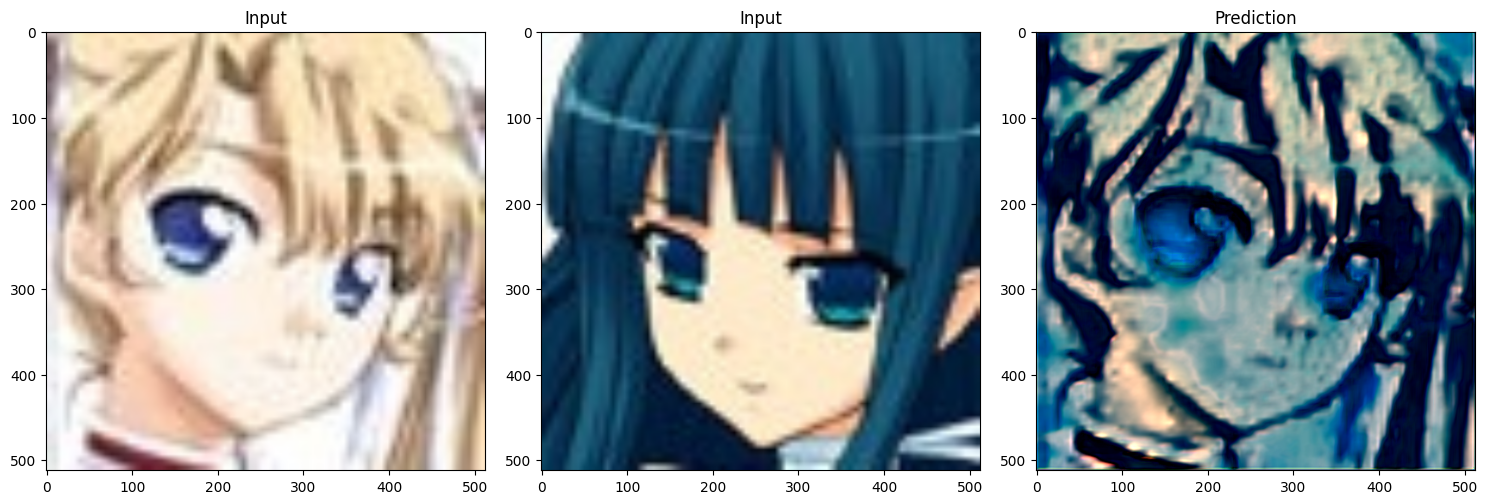

In [18]:
import matplotlib.pyplot as plt

# Plot the input image
plt.figure(figsize=(15, 15))
plt.subplot(1, 3, 1)
x_trai1 = cv2.cvtColor(x_train[78], cv2.COLOR_BGR2RGB)
plt.imshow(x_trai1)
plt.title('Input')

# Plot the input image
plt.subplot(1, 3, 2)
x_trai2 = cv2.cvtColor(x_train[50], cv2.COLOR_BGR2RGB)
plt.imshow(x_trai2)
plt.title('Input')

# Plot the prediction
plt.subplot(1, 3, 3)
pred = cv2.cvtColor(prediction_rescaled[0], cv2.COLOR_BGR2RGB)
plt.imshow(pred)
plt.title('Prediction')

plt.tight_layout()
plt.show()


In [19]:
dataset_dir2 = "/content/starry_night.jpg"
#
img = []

# for filename in os.listdir(dataset_dir1[0:5000]):
    # Load the image using OpenCV
Image = cv2.imread(dataset_dir2)

    # Resize the image to a desired size (e.g., 128x128)
Image = cv2.resize(Image, (512, 512,))

    # Append the image to the images list
img.append(Image)

fun_t = np.array(img)

In [20]:
dataset_dir1 = "/content/vettel.jpg"
#
images = []

# for filename in os.listdir(dataset_dir1[0:5000]):
    # Load the image using OpenCV
image = cv2.imread(dataset_dir1)

    # Resize the image to a desired size (e.g., 128x128)
image = cv2.resize(image, (512, 512,))

    # Append the image to the images list
images.append(image)

fun_T = np.array(images)

In [21]:
import numpy as np

# Assuming you already have the trained model 'unet'

#Assuming you have the test data stored in 'x_test'
# x_test0 = prediction1[0]  # Take a single sample from the training data
# x_test0 = np.expand_dims(x_test0, axis=0)

x_test1 = fun_T[0]  # Take a single sample from the training data
x_test1 = np.expand_dims(x_test1, axis=0)  # Add an extra dimension for the batch size

x_test2 = fun_t[0]  # Take a single sample from the training data
x_test2 = np.expand_dims(x_test2, axis=0)

# Make predictions
prediction1 = unet.transfer(x_test1,x_test2)
prediction_rescaled1 = (prediction1 - prediction1.min()) / (prediction1.max() - prediction1.min())


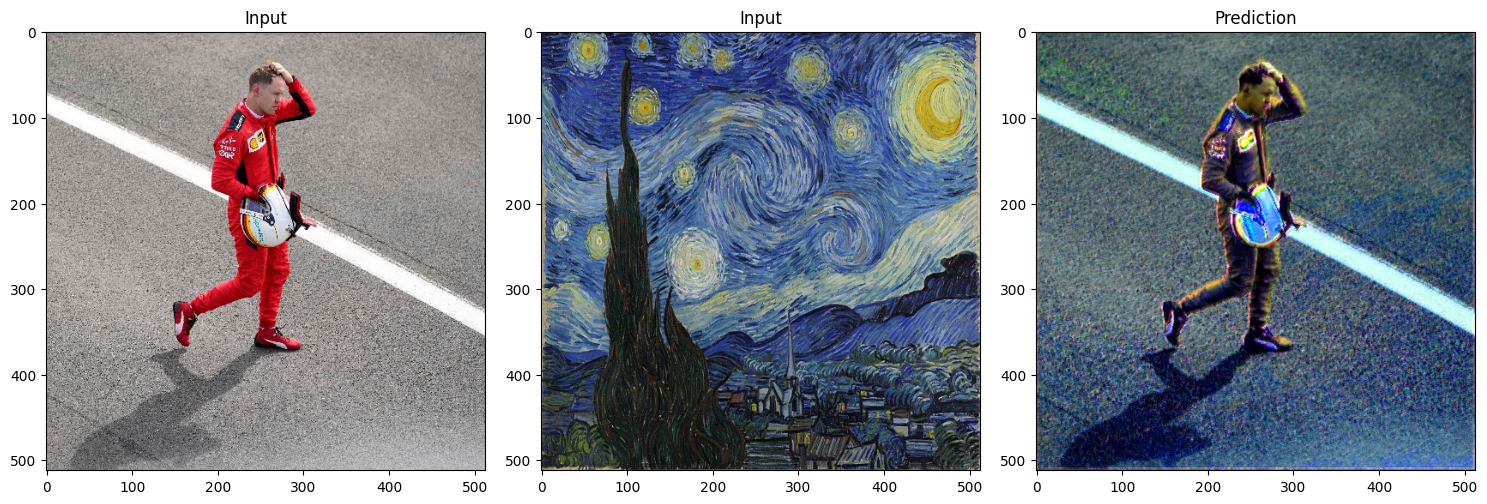

In [22]:
import matplotlib.pyplot as plt

# Assuming you already have the trained model 'unet'
# Assuming you have the test data stored in 'x_test'



# Plot the input image
plt.figure(figsize=(15, 15))
plt.subplot(1, 3, 1)
x_trai1 = cv2.cvtColor(fun_T[0], cv2.COLOR_BGR2RGB)
plt.imshow(x_trai1)
plt.title('Input')

# Plot the input image
plt.subplot(1, 3, 2)
x_trai2 = cv2.cvtColor(fun_t[0], cv2.COLOR_BGR2RGB)
plt.imshow(x_trai2)
plt.title('Input')

# Plot the prediction
plt.subplot(1, 3, 3)
pred1 = cv2.cvtColor(prediction_rescaled1[0], cv2.COLOR_BGR2RGB)
plt.imshow(pred1)
plt.title('Prediction')

plt.tight_layout()
plt.show()


# **Segmented Style**

Applying Style Transfer to Original Dataset

-> Applying anime style to Real People dataset

image_train -> Training Dataset of the real people data
x_train -> Training Dataset of the anime data

In [28]:
van_gogh = cv2.imread('/content/starry_night.jpg')
stars = cv2.cvtColor(van_gogh, cv2.COLOR_BGR2RGB)

stars_ar = np.array(van_gogh)

vettel = cv2.imread("/content/vettel.jpg")
vettel_ar = np.array(vettel)

In [29]:
x_test1 = vettel_ar
x_test1 = np.expand_dims(x_test1, axis=0)  # Add an extra dimension for the batch size

x_test2 = stars_ar  # Take a single sample from the training data
x_test2 = np.expand_dims(x_test2, axis=0)

prediction = unet.transfer(x_test1,x_test2)
prediction_rescaled = (prediction - prediction.min()) / (prediction.max() - prediction.min())

In [32]:
import cv2
import numpy as np

# Load the images
original_img = x_trai1
man_cutout = pred_mask
styled_man = masked_image1

# Load the images
original_img = np.array(original_img)
man_cutout = np.array(man_cutout)
styled_man = np.array(styled_man)

import matplotlib.pyplot as plt

# Convert the images to uint8 if they are not already
original_img = (original_img * 255).astype(np.uint8) if original_img.dtype != np.uint8 else original_img
styled_man = (styled_man * 255).astype(np.uint8) if styled_man.dtype != np.uint8 else styled_man

# Get a binary mask of the styled_man where the pixels are not black
mask = np.all(styled_man != [0, 0, 0], axis=-1)

# Create a copy of the original image
combined_img = original_img.copy()

# Replace the pixels of the original image with the styled_man pixels where the mask is True
combined_img[mask] = styled_man[mask]

# Display the result
plt.imshow(combined_img)
plt.show()



NameError: name 'pred_mask' is not defined

In [27]:
import cv2
import numpy as np

# Load the images
original_img = x_trai1
man_cutout = pred_mask
styled_man = masked_image1

# Load the images
original_img = np.array(original_img)
man_cutout = np.array(man_cutout)
styled_man = np.array(styled_man)

import matplotlib.pyplot as plt

# Convert the images to uint8 if they are not already
original_img = (original_img * 255).astype(np.uint8) if original_img.dtype != np.uint8 else original_img
styled_man = (styled_man * 255).astype(np.uint8) if styled_man.dtype != np.uint8 else styled_man

# Get a binary mask of the styled_man where the pixels are not black
mask = np.all(styled_man != [0, 0, 0], axis=-1)

# Create a copy of the original image
combined_img = original_img.copy()

# Replace the pixels of the original image with the styled_man pixels where the mask is True
combined_img[mask] = styled_man[mask]

# Display the result
plt.imshow(combined_img)
plt.show()



NameError: name 'pred_mask' is not defined

In [23]:
import numpy as np

# Assuming you already have the trained model 'unet'

# Assuming you have the test data stored in 'x_test'
x_test1 = image_train[70]  # Take a single sample from the training data
x_test1 = np.expand_dims(x_test1, axis=0)  # Add an extra dimension for the batch size

x_test2 = x_train[127]  # Take a single sample from the training data
x_test2 = np.expand_dims(x_test2, axis=0)

# Make predictions
prediction = unet.transfer(x_test1,x_test2)
prediction_rescaled = (prediction - prediction.min()) / (prediction.max() - prediction.min())

NameError: name 'image_train' is not defined

NameError: name 'image_train' is not defined

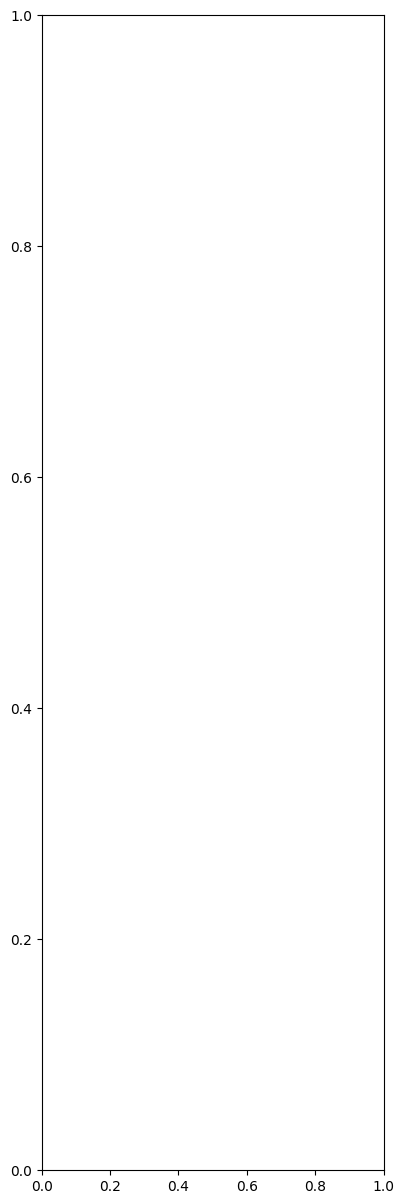

In [24]:
import matplotlib.pyplot as plt

# Assuming you already have the trained model 'unet'
# Assuming you have the test data stored in 'x_test'



# Plot the input image
plt.figure(figsize=(15, 15))
plt.subplot(1, 3, 1)
x_trai1 = cv2.cvtColor(image_train[70], cv2.COLOR_BGR2RGB)
plt.imshow(x_trai1)
plt.title('Input')

# Plot the input image
plt.subplot(1, 3, 2)
x_trai2 = cv2.cvtColor(x_train[127], cv2.COLOR_BGR2RGB)
plt.imshow(x_trai2)
plt.title('Input')

# Plot the prediction
plt.subplot(1, 3, 3)
pred = cv2.cvtColor(prediction_rescaled[0], cv2.COLOR_BGR2RGB)
plt.imshow(pred)
plt.title('Prediction')

plt.tight_layout()
plt.show()

In [25]:
# Assuming you already have the trained model 'unet'
# Take a single sample from the training data
x_test = image_train[70]
x_test = np.expand_dims(x_test, axis=0)

# Make predictions
prediction = u.predict(x_test)
print(prediction.dtype)
pred_mask = create_mask(prediction)

mask_pred = np.array(pred_mask)
mask_pred = mask_pred.astype(np.uint8)
masked_image1 = cv2.bitwise_and(pred, pred, mask=mask_pred)


plt.figure(figsize=(20, 20))

# Plot the input image
plt.subplot(1, 5, 1)
x_trai1 = cv2.cvtColor(image_train[70], cv2.COLOR_BGR2RGB)
plt.imshow(x_trai1)
plt.title('Input')


# Plot the input image
plt.subplot(1, 5, 2)
plt.imshow(pred)
plt.title('Input')

# Plot the prediction mask
plt.subplot(1, 5, 3)
plt.imshow(pred_mask)
plt.title('Prediction Mask')


plt.subplot(1, 5, 4)
plt.imshow(masked_image1)
plt.title('Prediction of Style Masked')


plt.tight_layout()
plt.show()



NameError: name 'image_train' is not defined

In [ ]:


# # Find the non-black pixels in the second image
# non_black_pixels = np.any(masked_image1 != [0, 0, 0], axis=-1)

# # Create the result image: pixels from image2 where image2 is not black, else from image1
# result1 = np.where(non_black_pixels[..., None], masked_image1, x_trai1)


In [ ]:
# print(result1.dtype)
# result1 = (result1 - np.min(result1)) / (np.max(result1) - np.min(result1))
# plt.imshow(result1)
# plt.show()

In [ ]:
# # Find the black pixels in the second image
# black_pixels = np.all(masked_image1 == [0, 0, 0], axis=-1)

# # Create the result image: pixels from image1 where image2 is black, else from image2
# result5 = np.where(black_pixels[..., None], masked_image1,x_trai1 )

In [ ]:
# print(result5.dtype)
# result5 = (result5 - np.min(result5)) / (np.max(result5) - np.min(result5))
# plt.imshow(result1)
# plt.show()

In [ ]:
# # Ensure all images are of type np.uint8
# original = image_train[60].astype(np.uint8)
# styled = masked_image1.astype(np.uint8)
# mask = pred_mask.numpy().astype(np.uint8)




In [ ]:
# import numpy as np

# # Ensure the mask is 3D
# if len(mask.shape) == 3:
#     # Convert mask to boolean where True indicates the region of the man
#     mask_boolean = mask[..., 0] > 0

#     # Extend mask_boolean to 3 channels
#     mask_boolean = np.stack([mask_boolean]*3, axis=-1)

# # Create a copy of the original image
# original_copy = np.copy(original)

# # Replace the region in the original image with the styled image
# styled_masked_1 = np.where(mask_boolean, styled, original_copy)

# plt.imshow(cv2.cvtColor(styled_masked_1, cv2.COLOR_BGR2RGB))
# plt.show()



In [ ]:
# import numpy as np

# # Ensure the mask is 3D
# if len(mask.shape) == 2:
#     # Convert mask to boolean where True indicates the region of the man
#     mask_boolean = mask > 0

#     # Extend mask_boolean to 3 channels
#     mask_boolean = np.stack([mask_boolean]*3, axis=-1)

# # Create a copy of the original image
# original_copy = np.copy(original)

# # Replace the region in the original image with the styled image
# styled_masked = np.where(mask_boolean, original_copy, styled)

# plt.imshow(cv2.cvtColor(styled_masked, cv2.COLOR_BGR2RGB))
# plt.show()


In [ ]:
# # OpenCV uses BGR color format. If the input images are in RGB format, convert them to BGR
# image_train_bgr = cv2.cvtColor(image_train[60], cv2.COLOR_RGB2BGR)
# masked_image1_bgr = cv2.cvtColor(masked_image1, cv2.COLOR_RGB2BGR)

# # Assuming original and styled images are in RGBA format (with 4th channel as alpha)
# original = cv2.cvtColor(image_train_bgr, cv2.COLOR_BGR2RGBA)
# styled = cv2.cvtColor(masked_image1_bgr, cv2.COLOR_BGR2RGBA)

# original = original.astype(np.uint8)
# styled = styled.astype(np.uint8)

# # Ensure the mask is a 2D array
# if len(mask.shape) == 3:
#     mask = mask.squeeze(axis=2)

# # Assign the mask to the alpha channel
# styled[..., 3] = mask


# # Alpha blending
# combined = cv2.addWeighted(original, 1, styled, 1, 0)


In [ ]:


# # Plot the input image
# plt.subplot(1, 2, 1)
# x_trai1 = cv2.cvtColor(image_train[60], cv2.COLOR_BGR2RGB)
# plt.imshow(x_trai1)
# plt.title('Input')

# # Display the combined image
# plt.subplot(1, 2, 2)
# plt.imshow(combined)
# plt.show()


In [ ]:
# plt.figure(figsize=(30, 30))

# # Plot the input image
# plt.subplot(2, 3, 1)
# x_trai1 = cv2.cvtColor(image_train[60], cv2.COLOR_BGR2RGB)
# plt.imshow(x_trai1)
# plt.title('Input')


# # Plot the input image
# plt.subplot(2, 3, 2)
# plt.imshow(pred)
# plt.title('Input')

# # Plot the prediction mask
# plt.subplot(2, 3, 3)
# plt.imshow(pred_mask)
# plt.title('Prediction Mask')

# #Plot the inverted mask
# plt.subplot(2,3,4)
# plt.imshow(cv2.cvtColor(styled_masked_1, cv2.COLOR_BGR2RGB))
# plt.title('Inverted Masking')

# plt.subplot(2, 3, 5)
# plt.imshow(masked_image1)
# plt.title('Prediction of Style Masked')

# plt.subplot(2, 3, 6)

# plt.imshow(cv2.cvtColor(combined, cv2.COLOR_BGR2RGB))
# plt.title('Stiched Result')

# plt.tight_layout()
# plt.show()


In [ ]:
# cood = np.array(masked_image1)
# org = np.array(x_trai1)


In [ ]:
# import matplotlib.pyplot as plt
# import numpy as np

# # Assuming that 'original', 'styled', and 'mask' are your images
# # Also assuming they are NumPy arrays with the same dimensions (height, width, 3 for color images)

# # Convert mask to boolean where True indicates the region of the man
# mask_boolean = cood > 0
# #print(mask_boolean)
# # Create a copy of the original image
# original_copy = np.copy(org)

# # Replace the region in the original image with the styled image
# original_copy[mask_boolean] = cood[mask_boolean]

# # Plotting
# plt.figure(figsize=(15, 10))

# # Plot original image
# plt.subplot(1, 3, 1)
# plt.imshow(org)
# plt.title('Original')

# # Plot styled image
# plt.subplot(1, 3, 2)
# plt.imshow(cood)
# plt.title('Styled')

# # Plot combined image
# plt.subplot(1, 3, 3)
# plt.imshow(original_copy)
# plt.title('Combined')

# plt.tight_layout()
# plt.show()


In [ ]:
# # Assuming that `original` is your original image and `styled` is your styled image
# # Both images should be in the same shape and datatype

# # Create a copy of the original image to avoid changing it
# result6 = org.copy()

# # Iterate over each pixel
# for i in range(org.shape[0]):        # Loop over rows
#     for j in range(org.shape[1]):    # Loop over columns
#         # If the styled pixel is not black, replace the corresponding pixel in the original image
#         if np.any(cood[i, j] != [0, 0, 0]):    # Using np.any to handle multi-channel images (e.g., RGB)
#             result6[i, j] = cood[i, j]

# # Now, `result` is your original image with the non-black pixels of the styled image

# # Plotting
# plt.imshow(result6)
# plt.show()


In [ ]:
# import cv2
# import numpy as np

# # Assume src is your source image (styled man) and dst is your destination image (original image)
# src = masked_image1
# dst = x_trai1
# # Make sure the source image (styled cutout) is the same size as the cutout from the original image
# src = cv2.resize(src, (dst.shape[1], dst.shape[0]))

# # Convert the images to 8 bit
# src = src.astype(np.uint8)
# dst = dst.astype(np.uint8)

# # The mask should be the same size as the source image and have 0 where the source image should not be placed
# # and 255 where it should be placed.
# # Since we want to place the entire source image, the mask is just a matrix of 255s
# mask = 255 * np.ones(src.shape[:2], dtype=np.uint8)

# # The location in the destination image where the center of the source image should be placed
# width, height, channels = dst.shape
# center = (height//2, width//2)

# # Use cv2.seamlessClone() to combine the images
# result = cv2.seamlessClone(src, dst, mask, center, cv2.NORMAL_CLONE)

# # Now, result is your original image with the styled man image placed seamlessly on top

# # Display the image
# plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))



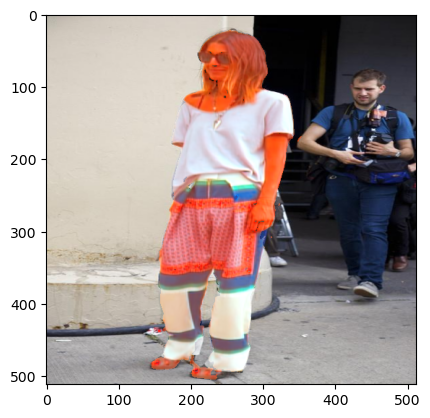

In [ ]:
import cv2
import numpy as np

# Load the images
original_img = x_trai1
man_cutout = pred_mask
styled_man = masked_image1

# Load the images
original_img = np.array(original_img)
man_cutout = np.array(man_cutout)
styled_man = np.array(styled_man)

import matplotlib.pyplot as plt

# Convert the images to uint8 if they are not already
original_img = (original_img * 255).astype(np.uint8) if original_img.dtype != np.uint8 else original_img
styled_man = (styled_man * 255).astype(np.uint8) if styled_man.dtype != np.uint8 else styled_man

# Get a binary mask of the styled_man where the pixels are not black
mask = np.all(styled_man != [0, 0, 0], axis=-1)

# Create a copy of the original image
combined_img = original_img.copy()

# Replace the pixels of the original image with the styled_man pixels where the mask is True
combined_img[mask] = styled_man[mask]

# Display the result
plt.imshow(combined_img)
plt.show()



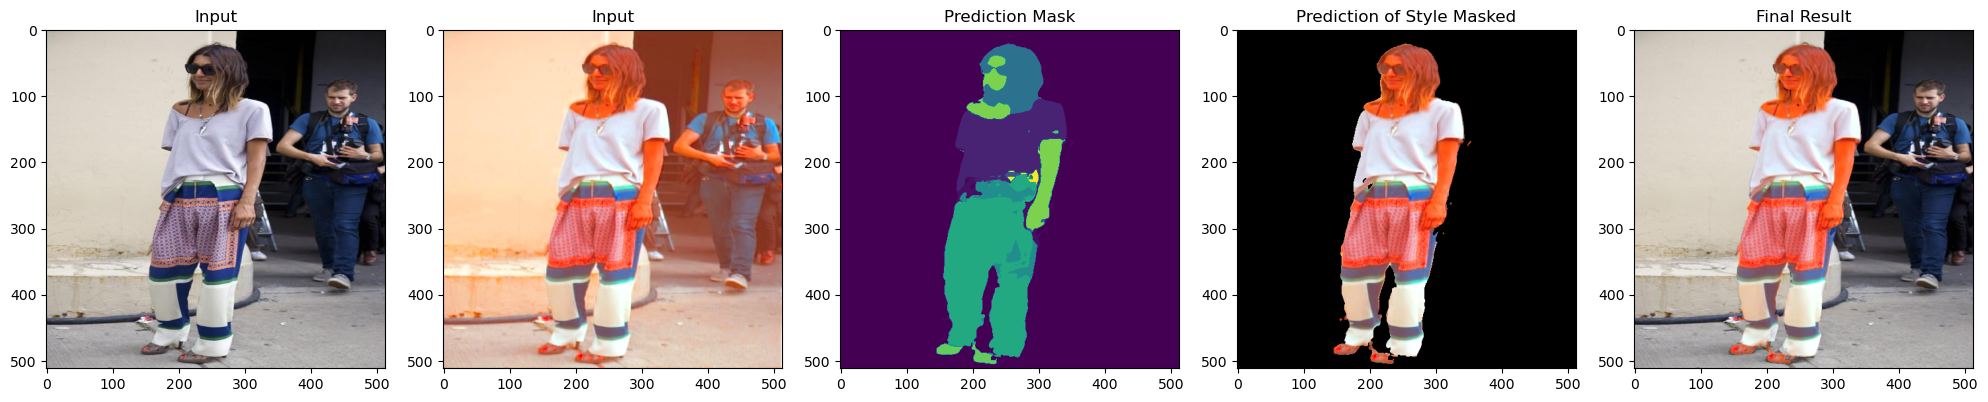

In [ ]:
plt.figure(figsize=(20, 20))

# Plot the input image
plt.subplot(1, 5, 1)
x_trai1 = cv2.cvtColor(image_train[70], cv2.COLOR_BGR2RGB)
plt.imshow(x_trai1)
plt.title('Input')


# Plot the input image
plt.subplot(1, 5, 2)
plt.imshow(pred)
plt.title('Input')

# Plot the prediction mask
plt.subplot(1, 5, 3)
plt.imshow(pred_mask)
plt.title('Prediction Mask')

#Plot the Styles Mask
plt.subplot(1, 5, 4)
plt.imshow(masked_image1)
plt.title('Prediction of Style Masked')

#Plot the final Stiched Image
plt.subplot(1 ,5, 5)
plt.imshow(combined_img)
plt.title('Final Result')

plt.tight_layout()
plt.show()